In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
def get_image(path, img_transform, size=(300, 300)):
  image = Image.open(path)
  image = image.resize(size, Image.LANCZOS)
  image = img_transform(image).unsqueeze(0)
  return image.to(device)


def get_gram(m):
  # m returns (1, c, h, w)
  _, c, h, w = m.size()
  m = m.view(c, h * w)
  m = torch.mm(m, m.t())
  return m


def denormalize_img(inp):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  return inp

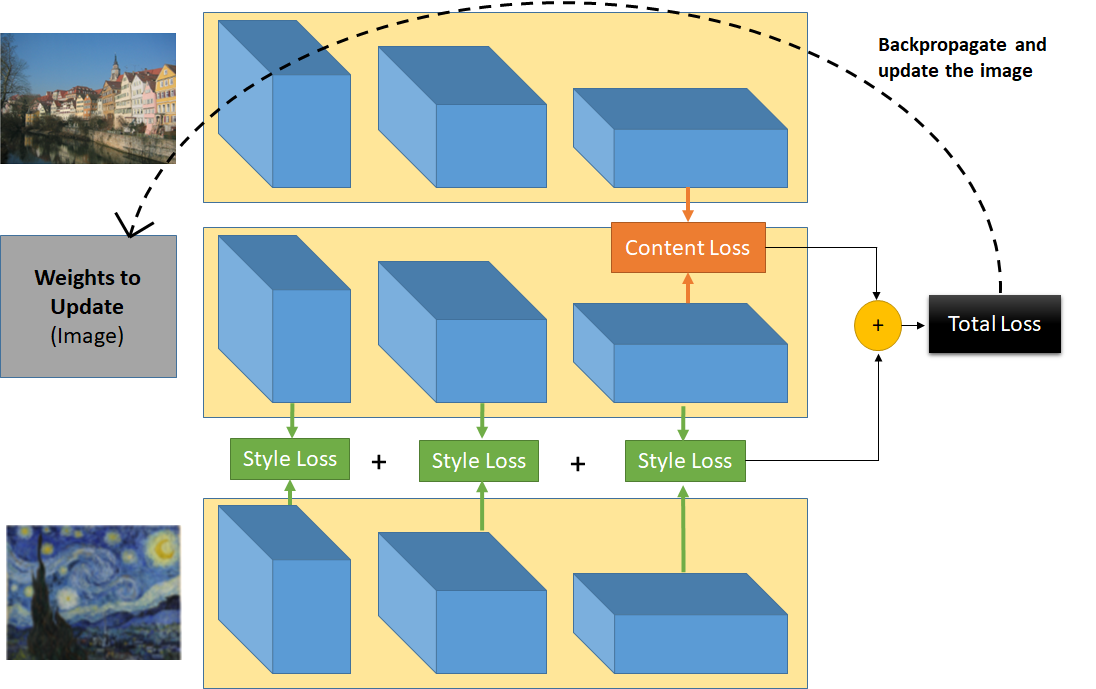

In [3]:
class FeatureExtractor(nn.Module):
  def __init__(self):
    super(FeatureExtractor, self).__init__()
    self.selected_layers = [3, 8, 15, 22]
    self.vgg = models.vgg16(pretrained=True).features


  def forward(self, x):
    layer_features = []
    for layer_number, layer in self.vgg._modules.items():
      x = layer(x)
      if int(layer_number) in self.selected_layers:
        layer_features.append(x)
    return layer_features


In [9]:
img_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])
content_img = get_image('content.jpg', img_transform)
style_img = get_image('style.jpg', img_transform)

generated_img = content_img.clone()
generated_img.requires_grad = True

optimizer = torch.optim.Adam([generated_img], lr=0.003, betas=[0.5, 0.999])
encoder = FeatureExtractor().to(device)

for p in encoder.parameters():
  p.requires_grad = False


In [10]:
content_weight = 1
style_weight = 100
epochs = 500
for epoch in range(epochs):
  content_features = encoder(content_img)
  style_features = encoder(style_img)
  generated_features = encoder(generated_img)

  content_loss = torch.mean((content_features[-1] - generated_features[-1] ** 2))
  style_loss = 0

  for gf, sf in zip(generated_features, style_features):
    _, c, h, w = gf.size()
    gram_gf = get_gram(gf)
    gram_sf = get_gram(sf)
    style_loss += torch.mean((gram_gf - gram_sf) ** 2) / (c * h * w)

  loss = content_weight * content_loss + style_weight * style_loss
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if epoch % 10 == 0:
    print('Epoch [{}]\tContent Loss: {:.4f}\tStyle Loss: {:.4f}'.format(epoch, content_loss.item(), style_loss.item()))


Epoch [0]	Content Loss: -6.9181	Style Loss: 2328.3767
Epoch [10]	Content Loss: -4.9767	Style Loss: 1850.2889
Epoch [20]	Content Loss: -4.0695	Style Loss: 1589.4185
Epoch [30]	Content Loss: -3.5327	Style Loss: 1412.1072
Epoch [40]	Content Loss: -3.1867	Style Loss: 1278.0464
Epoch [50]	Content Loss: -2.9438	Style Loss: 1169.8010
Epoch [60]	Content Loss: -2.7563	Style Loss: 1079.2332
Epoch [70]	Content Loss: -2.6067	Style Loss: 1001.3212
Epoch [80]	Content Loss: -2.4829	Style Loss: 933.2485
Epoch [90]	Content Loss: -2.3749	Style Loss: 873.2495
Epoch [100]	Content Loss: -2.2830	Style Loss: 819.8459
Epoch [110]	Content Loss: -2.2046	Style Loss: 771.9976
Epoch [120]	Content Loss: -2.1342	Style Loss: 728.8652
Epoch [130]	Content Loss: -2.0671	Style Loss: 689.7338
Epoch [140]	Content Loss: -2.0066	Style Loss: 654.0552
Epoch [150]	Content Loss: -1.9500	Style Loss: 621.3344
Epoch [160]	Content Loss: -1.8981	Style Loss: 591.1633
Epoch [170]	Content Loss: -1.8521	Style Loss: 563.2771
Epoch [180]	C

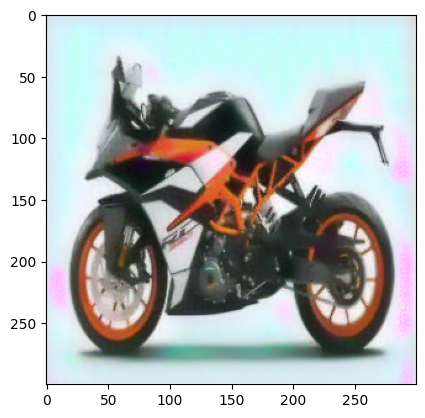

In [11]:
inp = generated_img.detach().cpu().squeeze()
inp = denormalize_img(inp)
plt.imshow(inp)